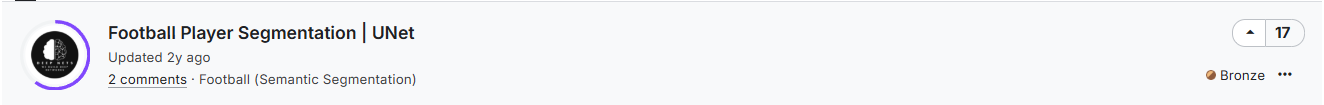

In [1]:
# Common
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Data 
from glob import glob
from tqdm import tqdm
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import multiply
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Model

# Model Visualization
from tensorflow.keras.utils import plot_model

In [2]:
#wandb
import wandb
from datetime import datetime
current_time = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
run_name = "run_" + current_time
wandb.login(key="a96035366c44c4ac930354c4d3bda0f9499c339e")
hyperparameter_defaults = dict(
    epochs = 50,
    batch_size = 1,
    img_size = 512
)
config = {
    "project":"PE Raodu Segmentation",
    "name": run_name,
    "config":hyperparameter_defaults
}
wandb.init(**config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: huchencao08 (huchencao08-shanghai-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Leaper\_netrc


In [3]:
# Root Path
image_paths = r'F:\dataSet\PE\QZYD\Raodu\Segment_DataSets'
image_paths = image_paths.replace("\\","/") + "/"
# All Images and thier respective maps
all_images = glob(image_paths + "*.BMP")
all_paths = [path.replace(".BMP","_mask.bmp") for path in all_images]

In [4]:
all_images[0]

'F:/dataSet/PE/QZYD/Raodu/Segment_DataSets\\20250304_190700_316_NG_Matting.BMP'

In [5]:
all_paths[0]

'F:/dataSet/PE/QZYD/Raodu/Segment_DataSets\\20250304_190700_316_NG_Matting_mask.bmp'

In [6]:
def load_image(path, SIZE=256):
    image = load_img(path)
    # 将PIL图像转换为NumPy数组
    image = img_to_array(image)
    image = tfi.resize(image, (SIZE, SIZE))
    image = img_to_array(image)
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

# def load_mask(path, SIZE=256):
#     mask = load_img(path)
#     mask = img_to_array(mask)
#     mask = tf.cast(mask, tf.float32)
#     mask = mask/255.
#     return mask

def load_data(image_paths, label_paths, SIZE=256):
    images, label_maps = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3)), np.zeros(shape=(len(label_paths), SIZE, SIZE, 1))
    for i, (image_path, label_path) in tqdm(enumerate(zip(image_paths, label_paths)), desc="Loading"):
        image, label_map = load_image(image_path, SIZE=SIZE), load_image(label_path, SIZE=SIZE)
        label_map_single = label_map[:,:,0]
        label_map_single = np.expand_dims(label_map_single, axis=-1)  # 添加通道维度
        images[i], label_maps[i] = image, label_map_single
    return images, label_maps

In [7]:
images, label_maps = load_data(all_images, all_paths, hyperparameter_defaults["img_size"])

Loading: 1236it [01:15, 16.31it/s]


In [8]:
def show_map(image, label_map, alpha_1=1, alpha_2=0.7):
    plt.imshow(image, alpha=alpha_1)
    plt.imshow(np.squeeze(label_map), alpha=alpha_2)
    plt.axis('off')

In [9]:
def show_maps(images, label_maps, GRID=[5,6], SIZE=(25,25)):
    
    # Plot Configuration
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    # Iterate through the Data
    i=1
    for image, label_map in zip(images, label_maps):
        
        # Plot Image
        plt.subplot(n_rows, n_cols, i)
        show_map(image, label_map)
        
        i+=1
        if i>n_images:
            break
    
    # Final Plot
    plt.show()

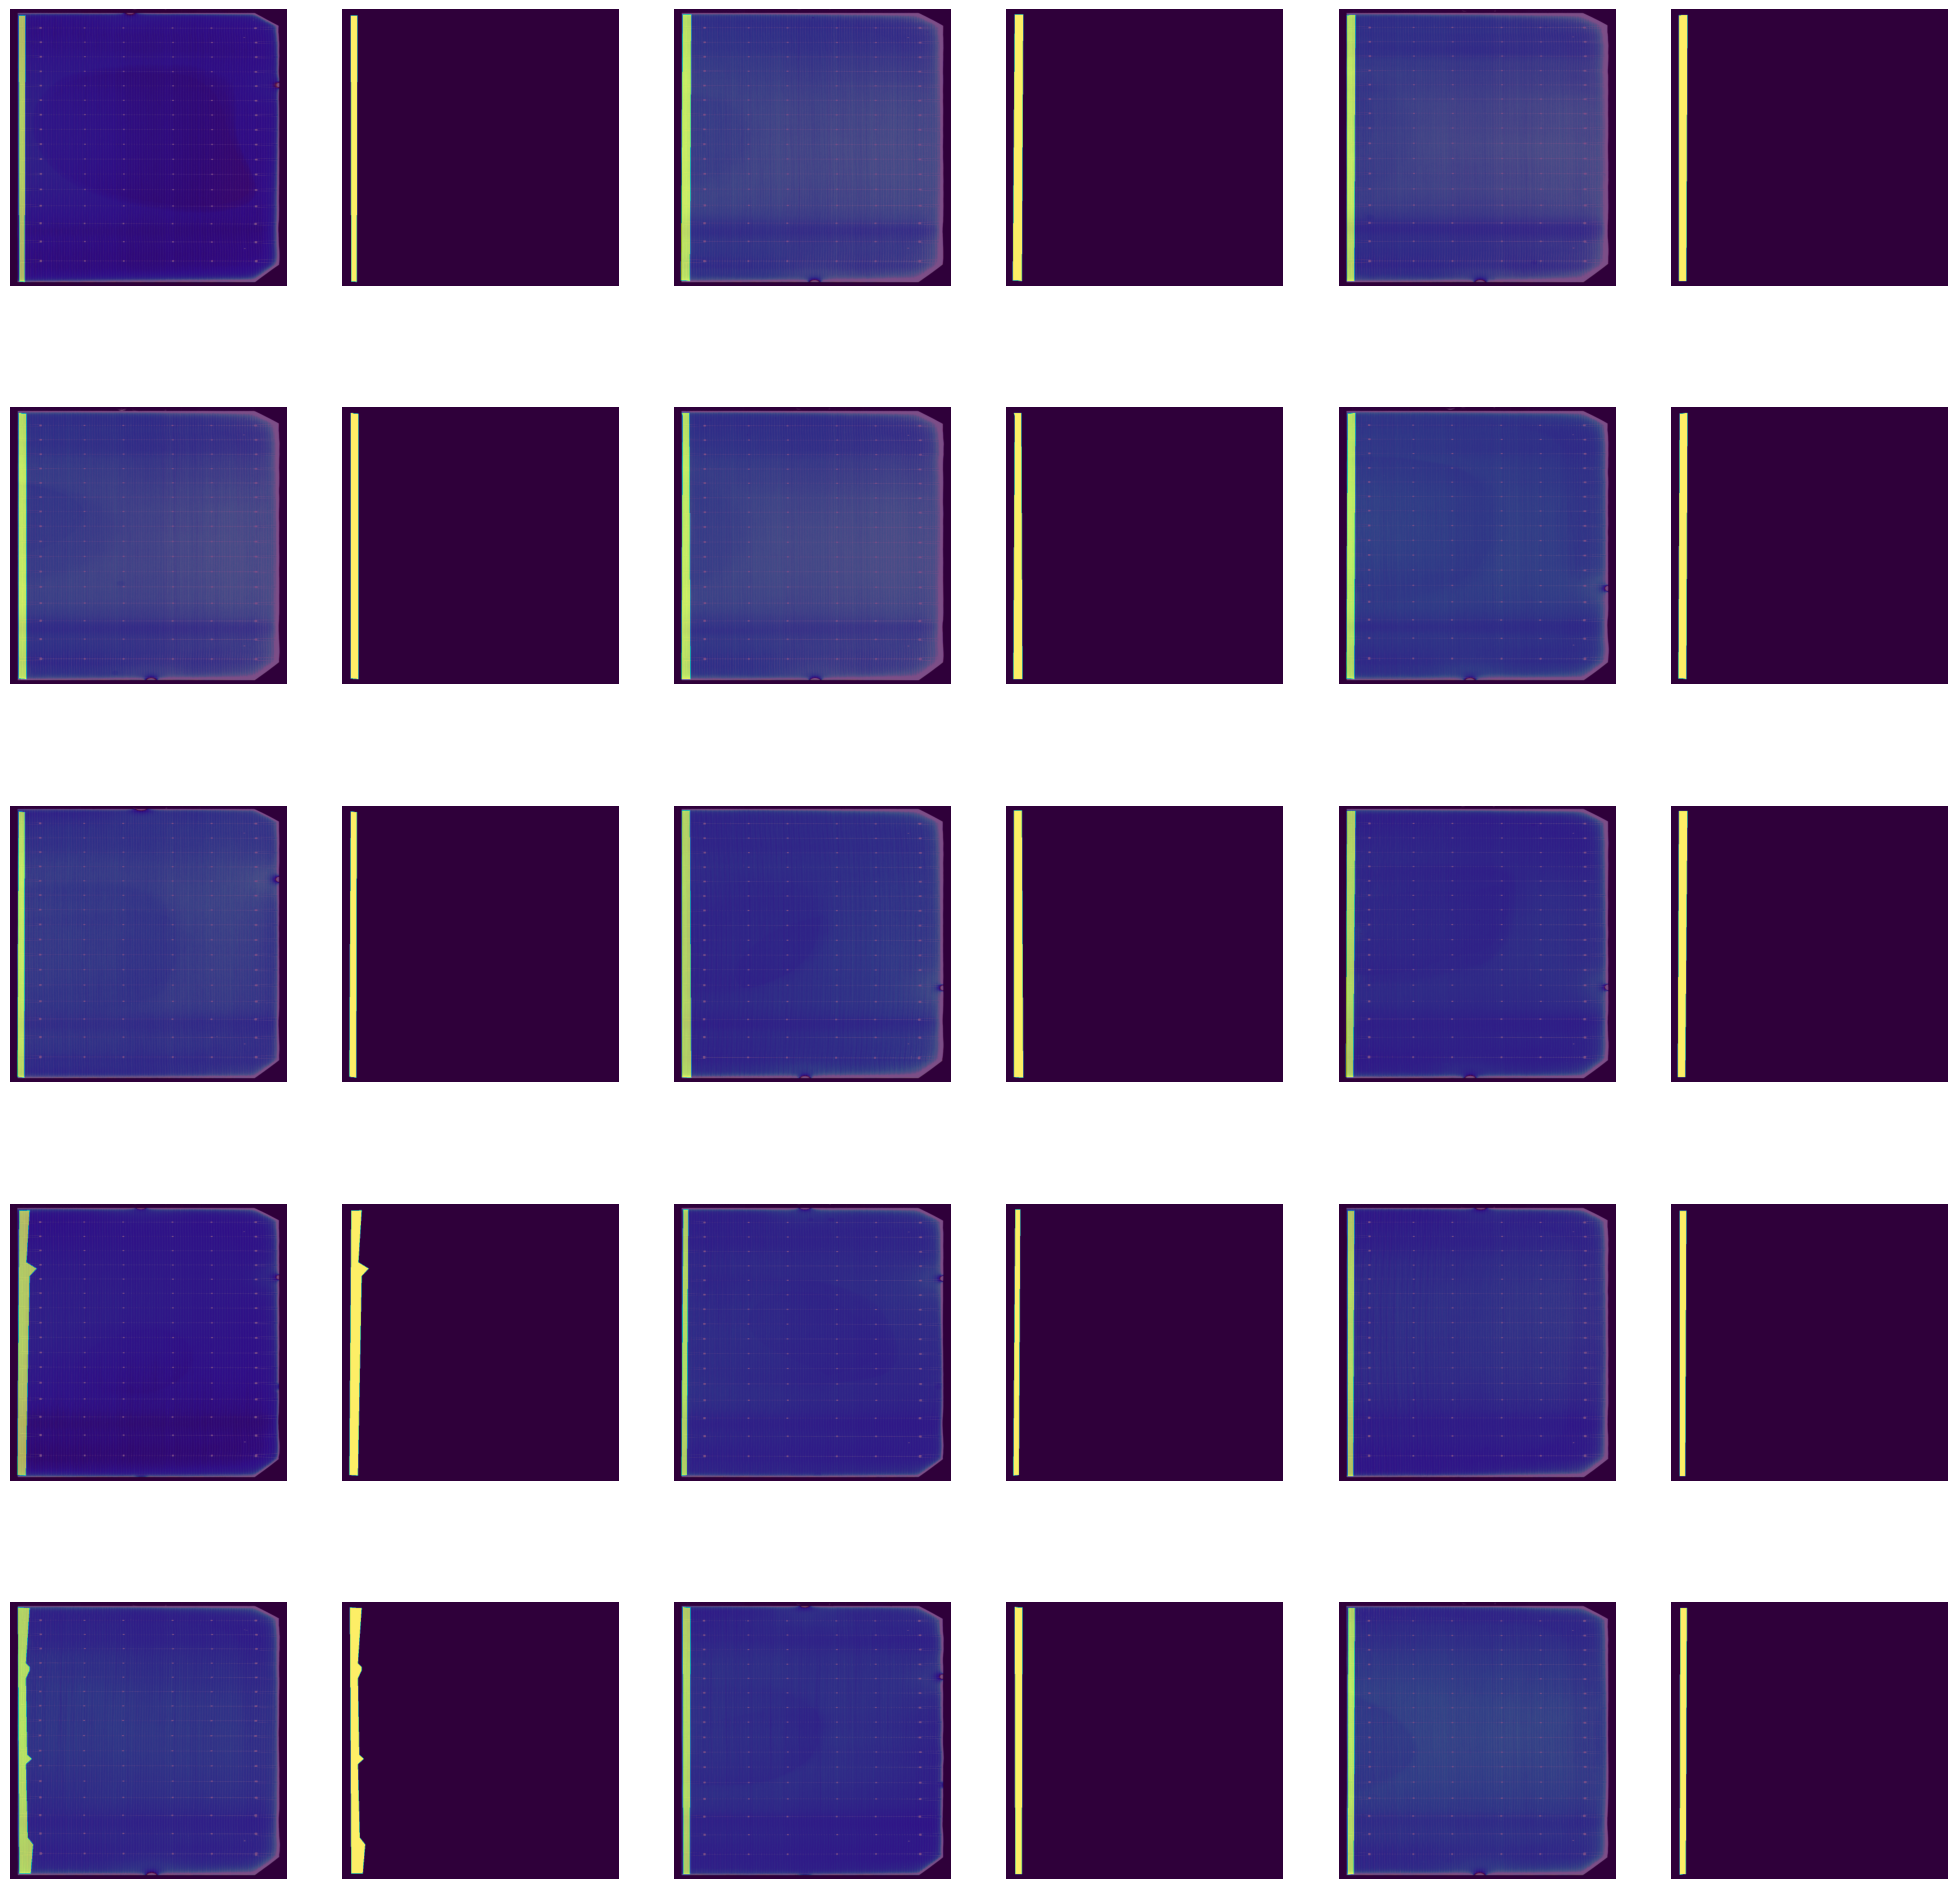

In [10]:
show_maps(images, label_maps)

In [11]:
class Encoder(Layer):
    
    def __init__(self, filters, rate=0.2, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    
    def call(self, X):
        x = self.c2(self.drop(self.c1(self.bn(X))))
        if self.pooling:
            y = self.pool(x)
            return x, y
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate,"pooling":self.pooling}

In [12]:
class Decoder(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.skip = Concatenate()
        self.net = Encoder(filters, rate, pooling=False)
    
    def call(self, X):
        x, skip_x = X
        y = self.cT(self.bn(x))
        y = self.net(self.skip([y, skip_x]))
        return y
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate}

In [13]:
# Input Layer
InputL = Input(shape=(hyperparameter_defaults["img_size"], hyperparameter_defaults["img_size"],3), name="InputImage")

# Encoder Block 
c1, p1 = Encoder(filters=64,  rate=0.1, name="Encoder1")(InputL)
c2, p2 = Encoder(filters=128, rate=0.1, name="Encoder2")(p1)
c3, p3 = Encoder(filters=256, rate=0.2, name="Encoder3")(p2)
c4, p4 = Encoder(filters=512, rate=0.2, name="Encoder4")(p3)


# # Encoding Layer
# encodings = Encoder(filters=512, rate=0.3, pooling=False, name="Encoding")(p4)
# 增加一次下采样（共5次）
c5, p5 = Encoder(filters=1024, rate=0.3, name="Encoder5")(p4)      # 32 -> 16.
encodings = Encoder(filters=1024, rate=0.3, pooling=False, name="Encoding")(p5)



# Decoder Block
d = Decoder(1024, 0.2, name='Decoder1')([encodings, c5])
d = Decoder(512, 0.2, name='Decoder2')([d, c4])
d = Decoder(256, 0.2, name='Decoder3')([d, c3])
d = Decoder(128, 0.1, name='Decoder4')([d, c2])
d = Decoder(64, 0.1, name='Decoder5')([d, c1])

# Output
conv_out = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name="Segmentator")(d)

# Model
model = Model(InputL, conv_out, name="UNet")
model.summary()

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputImage (InputLayer)         [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Encoder1 (Encoder)              ((None, 512, 512, 64 38732       InputImage[0][0]                 
__________________________________________________________________________________________________
Encoder2 (Encoder)              ((None, 256, 256, 12 221696      Encoder1[0][1]                   
__________________________________________________________________________________________________
Encoder3 (Encoder)              ((None, 128, 128, 25 885760      Encoder2[0][1]                   
_______________________________________________________________________________________________

In [14]:
#plot_model(model, "UNet.png", show_shapes=True)

In [15]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

def show_mask(mask, title=None):
    plt.imshow(np.squeeze(mask))
    plt.title(title)
    plt.axis('off')

In [16]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(images))
        image = images[id]
        mask = label_maps[id]
        pred_mask = self.model(tf.expand_dims(image,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,3,2)
        show_mask(mask, title="Original Mask")
        
        plt.subplot(1,3,3)
        show_mask(pred_mask, title="Predicted Mask")
            
        plt.tight_layout()
        plt.show()

In [17]:
from wandb.integration.keras import WandbCallback
callbacks = [ModelCheckpoint("UNet-Footbal-Player-Segmentation.h5", save_best_only=True),
             WandbCallback(save_graph=False,
                           save_model=False),
             ShowProgress()]

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/50
1236/1236 [==============================] - 569s 448ms/step - loss: 0.0421 - accuracy: 0.9852 - val_loss: 0.1412 - val_accuracy: 0.9546


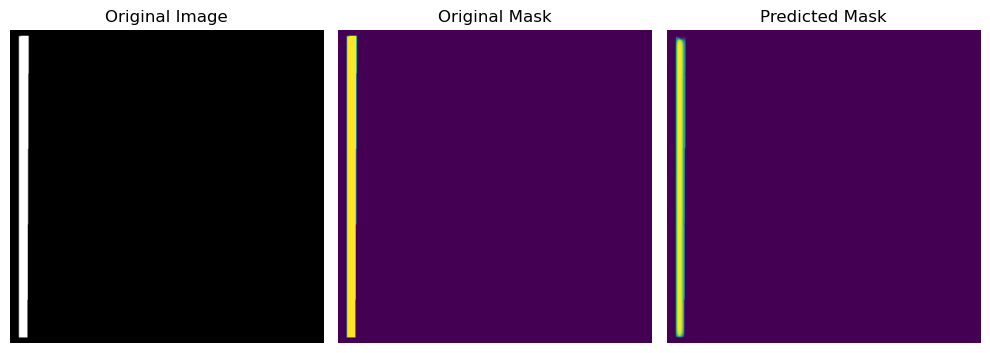

Epoch 2/50
 742/1236 [=================>............] - ETA: 3:53 - loss: 0.0169 - accuracy: 0.9930

KeyboardInterrupt: 

In [18]:
SPE = len(images)//hyperparameter_defaults["batch_size"]
model.fit(
    images, label_maps,
    validation_split=0.1,
    epochs=hyperparameter_defaults["epochs"],
    batch_size=hyperparameter_defaults["batch_size"],
    steps_per_epoch=SPE,
    callbacks=callbacks
)

In [ ]:
class Decoder(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.skip = Concatenate()
        self.net = Encoder(filters, rate, pooling=False)
    
    def call(self, X):
        x, skip_x = X
        y = self.cT(self.bn(x))
        y = self.net(self.skip([y, skip_x]))
        return y
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate}

In [ ]:
class Encoder(Layer):
    
    def __init__(self, filters, rate=0.2, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()
    
    def call(self, X):
        x = self.c2(self.drop(self.c1(self.bn(X))))
        if self.pooling:
            y = self.pool(x)
            return x, y
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "filters":self.filters, "rate":self.rate,"pooling":self.pooling}

In [ ]:
#model.save("UNetSegmentation.h5")

TypeError: save() got an unexpected keyword argument 'custom_objects'

True

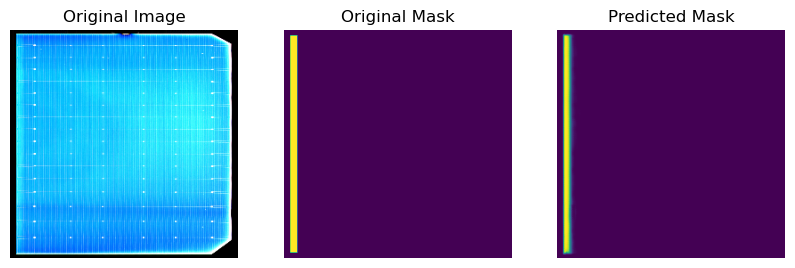

In [ ]:
#test
custom_objects={
    'Encoder': Encoder,
    'Decoder': Decoder
    }
model = tf.keras.models.load_model('UNetSegmentation.h5',
                                   custom_objects=custom_objects)
test_image = images[200]
test_mask = label_maps[200]
pred_mask = model(tf.expand_dims(test_image, axis=0))[0]
plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
show_image(test_image, title="Original Image")

plt.subplot(1,3,2)
show_mask(test_mask, title="Original Mask")

plt.subplot(1,3,3)
show_mask(pred_mask, title="Predicted Mask")
import cv2
test_image = (test_image * 255).astype(np.uint8)
test_image = cv2.resize(test_image, (1024, 2048))
cv2.imwrite('test_image.jpg', test_image)

test_mask = (test_mask * 255).astype(np.uint8)
test_mask = cv2.resize(test_mask, (1024, 2048))
cv2.imwrite('test_mask.jpg', test_mask)

pred_mask = pred_mask.numpy()  # 转换为 NumPy 数组
# 确保数据类型是 uint8
pred_mask = (pred_mask * 255).astype(np.uint8)
pred_mask = cv2.resize(pred_mask, (1024, 2048))
cv2.imwrite('pred_mask.jpg', pred_mask)

In [ ]:
testImg_path = r"F:\F_Problems_solve\2025.03.12_大绕度误判\testDataSets\matting\ng"
testImg_path = testImg_path.replace("\\","/") + "/"
all_testImages = glob(testImg_path + "*.BMP")
print(len(all_testImages))

336


In [ ]:
test_images, label_maps = load_data(all_testImages, all_paths)

Loading: 336it [00:19, 16.85it/s]


In [ ]:
for i, img in enumerate(test_images):
    pred_mask = model(tf.expand_dims(img, axis=0))[0]
    pred_mask = pred_mask.numpy()  # 转换为 NumPy 数组
    # 确保数据类型是 uint8
    pred_mask = (pred_mask * 255).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (1024, 2048))
    pred_mask = cv2.threshold(pred_mask, 100, 255, cv2.THRESH_BINARY)[1]
    #cv2.imwrite(f"pred_mask_{i}.png", pred_mask)

    img = (img * 255).astype(np.uint8)
    img = cv2.resize(img, (1024, 2048))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"./output/ng_ori/oriImg_{i}.png", img)
    #plt.figure(figsize=(10,8))
    #plt.subplot(i // 2 + 1,2,1)
    #show_image(img, title="Original Image")
    
    # plt.subplot(i // 2 + 1,2,2)
    # show_mask(pred_mask, title="Predicted Mask")
    # plt.tight_layout()
    # plt.show()

    maskContours = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, maskContours[0], -1, (0, 255, 0), 2)
    cv2.imwrite(f"./output/ng/ori_mask_ng{i}.png", img)
    